In [248]:
%matplotlib ipympl

In [249]:
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
import numpy as np
import scipy
from impedance.visualization import plot_nyquist
import matplotlib.pyplot as plt


In [250]:
def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [251]:
@element(num_params=3, units=["Ohm", "Ohm", "F"],overwrite=True)
def TLMlinNew(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q = p[0], p[1], p[2]
    t12=R1/R2
    Rion1=R1
    wclin=1/(Rion1*Q)
    S=np.sqrt(1j*omega/wclin)

    Z = (2*R1/S)*(scipy.special.iv(1/3, -2/3*(S*(t12**(-1/2)/(t12-1))))*scipy.special.iv(2/3, -2/3*(t12*S/(t12-1)))-scipy.special.iv(-1/3, -2/3*(S*t12**(-1/2)/(t12-1)))*scipy.special.iv(-2/3, -2/3*(t12*S/(t12-1))))/((scipy.special.iv(-1/3, -2/3*(S*t12**(-1/2)/(t12-1))))*scipy.special.iv(1/3, -2/3*(t12*S/(t12-1)))-scipy.special.iv(1/3, -2/3*(S*t12**(-1/2)/(t12-1)))*scipy.special.iv(-1/3, -2/3*(t12*S/(t12-1))))
    return Z

@element(num_params=3, units=["Ohm", "Ohm", "F"],overwrite=True)
def TLMlinzertNew(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q = p[0], p[1], p[2]
    tlin1=R1
    tlin2=R2
    eps=(tlin2-tlin1)/tlin1
    S=np.sqrt((R1*Q*omega*1j))

    Z=2*(R1)*((np.exp(2*S)+1)**2
        /(eps*(S**2+0.5)*np.exp(2*S)+(-eps/4+S)*np.exp(4*S)-eps/4-S))
    
    return Z

@element(num_params=3, units=["Ohm", "Ohm", "F"],overwrite=True)
def TLMlinsemiNew(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q = p[0], p[1], p[2]
    tlin1=R1
    tlin2=R2
    t12=tlin1/tlin2
    Rion1=R1
    Rion2=R2
    wclin1=1/(Rion1*Q)
    wclin2=1/(Rion2*Q)
    S1=np.sqrt(1j*omega/wclin1)
    kk=-(2/3)*t12*S1/(t12-1)

    Z = (2*R1/S1)*(scipy.special.iv(-2/3,kk)-scipy.special.iv(2/3,kk))/(scipy.special.iv(-1/3,kk)-scipy.special.iv(1/3,kk))
    
    return Z

@element(num_params=3, units=["Ohm", "Ohm", "F"],overwrite=True)
def TLMlinNewMix(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q = p[0], p[1], p[2]
    t12_lin=R1/R2
    Rion1_lin=R1
    wc_lin=1/(Rion1_lin*Q)
    
    wclin_new=wc_lin*100
    idx=find_index_of_nearest(omega,wclin_new)
    omega_low=omega[0:idx]
    omega_high=omega[idx:len(omega)]

    S_lin=np.sqrt(1j*omega_low/wc_lin)
    kk1_lin=-2/3*(S_lin*(t12_lin**(-1/2)/(t12_lin-1)))   
    kk2_lin=-2/3*(t12_lin*S_lin/(t12_lin-1))

    Z_lin = (2*Rion1_lin/S_lin)*(scipy.special.iv(1/3, kk1_lin)*scipy.special.iv(2/3, kk2_lin)-scipy.special.iv(-1/3, kk1_lin)*scipy.special.iv(-2/3,kk2_lin))/((scipy.special.iv(-1/3, kk1_lin))*scipy.special.iv(1/3, kk2_lin)-scipy.special.iv(1/3, kk1_lin)*scipy.special.iv(-1/3, kk2_lin))

    #calc Z semi
    tlin1=R1
    tlin2=R2
    t12=tlin1/tlin2
    Rion1=R1
    wc_semi=1/(Rion1*Q)
    S1_semi=np.sqrt(1j*omega_high/wc_semi)
    kk=-(2/3)*t12*S1_semi/(t12-1)

    Z_semi = (2*R1/S1_semi)*(scipy.special.iv(-2/3,kk)-scipy.special.iv(2/3,kk))/(scipy.special.iv(-1/3,kk)-scipy.special.iv(1/3,kk))

    # #calc Z pert
    # tlin1=R1
    # tlin2=R2   
    # eps=(tlin2-tlin1)/tlin1
    # S_pert=np.sqrt((R1*Q*omega_high*1j))
    # Z_pert=2*(R1)*((np.exp(2*S_pert)+1)**2
    #     /(eps*(S_pert**2+0.5)*np.exp(2*S_pert)+(-eps/4+S_pert)*np.exp(4*S_pert)-eps/4-S_pert))   

    # eps_c=0.05 #i.e. 5% diff between t1 and t2
    # if eps<eps_c:
    #     Z_high=Z_pert
    # else:
    #     Z_high=Z_semi
    Z_high=Z_semi
    Z_low=Z_lin

    return np.append(Z_low,Z_high)

@element(num_params=3, units=["Ohm", "Ohm", "F"],overwrite=True)
def TLMlinzertNewSecondFirst(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q = p[0], p[1], p[2]
    tlin1=R1
    tlin2=R2
    eps=(tlin2-tlin1)/tlin1
    S=np.sqrt((R1*Q*omega*1j))
    #first expansion
    Z=2*4*R1*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4+2*S**3+2*S**2+3/2*S+9/8)*eps**2+(4*S**3+S)*eps-4*S**2)*np.exp(2*S)+((-S**4+2*S**3-2*S**2+3/2*S-9/8)*eps**2+(4*S**3+S)*eps+4*S**2)*np.exp(4*S)+(-(1/8)*eps**2-S*eps+4*S**2)*np.exp(6*S)-4*S**2-S*eps+(1/8)*eps**2))
    return Z

@element(num_params=3, units=["Ohm", "Ohm", "F"],overwrite=True)
def TLMlinzertNewSecondSecond(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q = p[0], p[1], p[2]
    tlin1=R1
    tlin2=R2
    eps=(tlin2-tlin1)/tlin1
    S=np.sqrt((R1*Q*omega*1j))

    #second expansion
    Z=2*4*R1*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4-2/3*(S**3)+2*S**2-5/2*S+1/8)*eps**2+(4*S**3+S)*eps-4*S**2)*np.exp(2*S)+((-S**4-2/3*(S**3)-2*S**2-5/2*S-1/8)*eps**2+(4*S**3+S)*eps+4*S**2)*np.exp(4*S)+(4*S**2-S*eps+7/8*(eps**2))*np.exp(6*S)-4*S**2-S*eps-7*eps**2*(1/8)))
    return Z

In [252]:
# Rref=194.56
# t1=6.26
# R1=Rref*t1
# t2=2 
# R2=Rref*t2
# Q=6.61e-4

In [253]:
initial_guess=[1.1,1,6.61e-4]
tlmlin=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinNew_0')
tlmlin_zert=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinzertNew_0')
tlmlin_semi=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinsemiNew_0')
tlmlin_mix=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinNewMix_0')
tlmlin_zert_21=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinzertNewSecondFirst')
tlmlin_zert_22=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinzertNewSecondSecond')


In [254]:
##just code to check plotting from diff freq ranges
# f_pred_c=1/(2*np.pi*194.56*4*6.61e-4)
# f_pred_c_lin_new=f_pred_c*10
# idx=find_index_of_nearest(f_pred,f_pred_c_lin_new)
# f_low=f_pred[0:idx]
# f_high=f_pred[idx:len(f_pred)]

#printing the f_pred, high and low
#print(f_pred,f_low,f_high)

In [255]:
f_pred = np.logspace(-3,3,num=50)

tlmlin_pred = tlmlin.predict(f_pred)
tlmlin_zert_pred=tlmlin_zert.predict(f_pred)
tlmlin_semi_pred=tlmlin_semi.predict(f_pred)
tlmlin_mix_pred=tlmlin_mix.predict(f_pred)
tlmlin_zert_21_pred=tlmlin_zert_21.predict(f_pred)
tlmlin_zert_22_pred=tlmlin_zert_22.predict(f_pred)

In [256]:
# ax= plt.figure().add_subplot()
# # factor=194.56/1.5
# factor=1
# ax.plot(np.real(tlmlin_pred/factor),-np.imag(tlmlin_pred/factor),"r",label="lin")
# ax.plot(np.real(tlmlin_zert_pred/factor),-np.imag(tlmlin_zert_pred/factor),"b",label="lin_pert")
# #ax.plot(np.real(tlmlin_semi_pred)/factor,-np.imag(tlmlin_semi_pred)/factor,"g",label="lin_semi")
# #ax.plot(np.real(tlmlin_mix_pred)/factor,-np.imag(tlmlin_mix_pred)/factor,"y",label="lin_mix")
# ax.plot(np.real(tlmlin_zert_21_pred)/factor,-np.imag(tlmlin_zert_21_pred)/factor,"pink",label="lin_pert_21")
# ax.plot(np.real(tlmlin_zert_22_pred)/factor,-np.imag(tlmlin_zert_22_pred)/factor,"g",label="lin_pert_22")
# ax.legend()
# ax.set_xlabel("Re(Z)")
# ax.set_ylabel("-Im(Z)")
# ax.set_aspect("equal")
# ax.set_xlim(-4,200)
# ax.set_ylim(-1,200)

In [257]:
def give_chi_square(z1,z2):
    return np.sum((np.real(z1)-np.real(z2))**2), np.sum((np.imag(z1)-np.imag(z2))**2)

In [258]:
# print(give_chi_square(tlmlin_pred,tlmlin_zert_pred))
# print(give_chi_square(tlmlin_zert_21_pred,tlmlin_zert_22_pred))
# tlmlin_zert_pred
#tlmlin_zert_pred

In [259]:
def make_z_from_csv(filename):
    data_csv=np.genfromtxt(filename,delimiter=',')
    zz=data_csv[0]+1j*data_csv[1]
    return zz


In [260]:
z_lin_maple_100=make_z_from_csv("z_lin_data.csv")
z_lin_pert_maple_100=make_z_from_csv("z_lin_pert_data.csv")
z_lin_pert_21_maple_100=make_z_from_csv("z_lin_pert_21_data.csv")
z_lin_pert_22_maple_100=make_z_from_csv("z_lin_pert_22_data.csv")

In [261]:
z_lin_maple_100_100=make_z_from_csv("z_lin_data_R1R2_100.csv")
z_lin_pert_maple_100_100=make_z_from_csv("z_lin_pert_data_R1R2_100.csv")
z_lin_pert_21_maple_100_100=make_z_from_csv("z_lin_pert_21_data_R1R2_100.csv")
z_lin_pert_22_maple_100_100=make_z_from_csv("z_lin_pert_22_data_R1R2_100.csv")

In [262]:
z_lin_maple_100_1_point_1=make_z_from_csv("z_lin_data_R1R2_1point1.csv")
z_lin_pert_maple_100_1_point_1=make_z_from_csv("z_lin_pert_data_R1R2_1point1.csv")
z_lin_pert_21_maple_100_1_point_1=make_z_from_csv("z_lin_pert_21_data_R1R2_1point1.csv")
z_lin_pert_22_maple_100_1_point_1=make_z_from_csv("z_lin_pert_22_data_R1R2_1point1.csv")

(-1.0, 600.0)

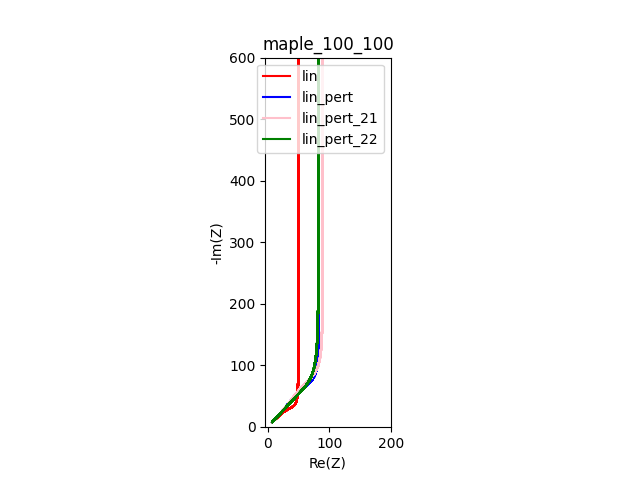

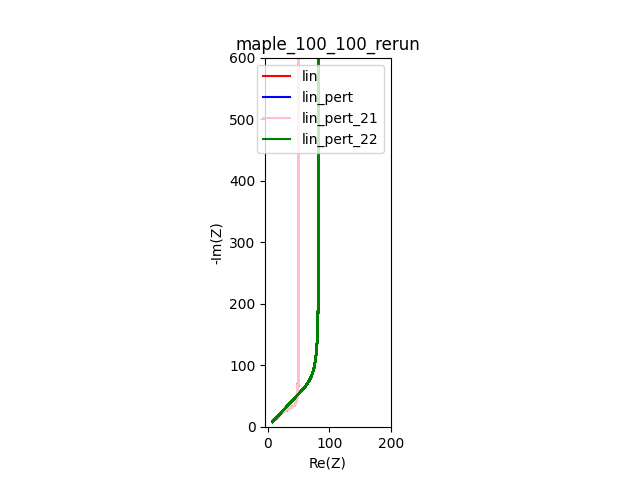

In [263]:
# ax= plt.figure().add_subplot()
# # factor=194.56/1.5
# factor=1
# ax.plot(np.real(tlmlin_pred/factor),-np.imag(tlmlin_pred/factor),"r",label="lin")
# ax.plot(np.real(tlmlin_zert_pred/factor),-np.imag(tlmlin_zert_pred/factor),"b",label="lin_pert")
# #ax.plot(np.real(tlmlin_semi_pred)/factor,-np.imag(tlmlin_semi_pred)/factor,"g",label="lin_semi")
# #ax.plot(np.real(tlmlin_mix_pred)/factor,-np.imag(tlmlin_mix_pred)/factor,"y",label="lin_mix")
# ax.plot(np.real(tlmlin_zert_21_pred)/factor,-np.imag(tlmlin_zert_21_pred)/factor,"pink",label="lin_pert_21")
# ax.plot(np.real(tlmlin_zert_22_pred)/factor,-np.imag(tlmlin_zert_22_pred)/factor,"g",label="lin_pert_22")
# ax.legend()
# ax.set_xlabel("Re(Z)")
# ax.set_ylabel("-Im(Z)")
# ax.set_aspect("equal")
# ax.set_xlim(0,1)
# ax.set_ylim(0,2)

ax4= plt.figure().add_subplot()
ax4.plot(np.real(z_lin_maple_100),-np.imag(z_lin_maple_100),"r",label="lin")
ax4.plot(np.real(z_lin_pert_maple_100),-np.imag(z_lin_pert_maple_100),"b",label="lin_pert")
ax4.plot(np.real(z_lin_pert_21_maple_100),-np.imag(z_lin_pert_21_maple_100),"pink",label="lin_pert_21")
ax4.plot(np.real(z_lin_pert_22_maple_100),-np.imag(z_lin_pert_22_maple_100),"g",label="lin_pert_22")
ax4.legend()
ax4.set_xlabel("Re(Z)")
ax4.set_ylabel("-Im(Z)")
ax4.set_aspect("equal")
ax4.set_title("maple_100_100")
ax4.set_xlim(-4,200)
ax4.set_ylim(-1,600)

ax6= plt.figure().add_subplot()
ax6.plot(np.real(z_lin_maple_100_100),-np.imag(z_lin_maple_100_100),"r",label="lin")
ax6.plot(np.real(z_lin_pert_maple_100_100),-np.imag(z_lin_pert_maple_100_100),"b",label="lin_pert")
ax6.plot(np.real(z_lin_pert_21_maple_100_100),-np.imag(z_lin_pert_21_maple_100_100),"pink",label="lin_pert_21")
ax6.plot(np.real(z_lin_pert_22_maple_100_100),-np.imag(z_lin_pert_22_maple_100_100),"g",label="lin_pert_22")
ax6.legend()
ax6.set_xlabel("Re(Z)")
ax6.set_ylabel("-Im(Z)")
ax6.set_aspect("equal")
ax6.set_title("maple_100_100_rerun")
ax6.set_xlim(-4,200)
ax6.set_ylim(-1,600)

# ax5= plt.figure().add_subplot()
# ax5.plot(np.real(z_lin_maple_100_1_point_1),-np.imag(z_lin_maple_100_1_point_1),"r",label="lin")
# ax5.plot(np.real(z_lin_pert_maple_100_1_point_1),-np.imag(z_lin_pert_maple_100_1_point_1),"b",label="lin_pert")
# ax5.plot(np.real(z_lin_pert_21_maple_100_1_point_1),-np.imag(z_lin_pert_21_maple_100_1_point_1),"pink",label="lin_pert_21")
# ax5.plot(np.real(z_lin_pert_22_maple_100_1_point_1),-np.imag(z_lin_pert_22_maple_100_1_point_1),"g",label="lin_pert_22")
# ax5.legend()
# ax5.set_xlabel("Re(Z)")
# ax5.set_ylabel("-Im(Z)")
# ax5.set_aspect("equal")
# ax5.set_xlim(0,1)
# ax5.set_ylim(0,2)
